# Coin Detection - Final Project

## Abstract

TBD

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import albumentations as A
import segmentation_models_pytorch as smp
from PIL import Image
import pandas as pd
from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm

from scripts.config import example_row

from scripts.models import CoinLocalizer, HierarchicalClassifier
from scripts.viz import plot_images
from scripts.training import train_model, get_best_available_device
from torch.utils.data import DataLoader
from scripts.utils import SegmentationDataset, split_data, get_segmentation, \
    plot_training, generate_hough, MergedTrainingDataset

## Segmentation

The first step in the path of classifying coins in images is to first localize them. For that purpose we will use segmentation model that consists of pretrained **ResNet backbone** (decoder) and **Unet encoder**. We have manually annotated the training images and generated binary masks that will make the training possible.

### Data Augmentation

As the amount of training data is limited and in order to make the model more robust so that **it would be able to work efficiently on the out-of-sample data**, we will augment the dataset by applying geometric and color transformations. What is more, we resize the image ten times as feeding 6000x4000px images to the neural network wouldn't be feasible. 

In [28]:
# define data augmentation for training and validation
train_tf = A.Compose([
    A.Resize(width=600, height=400, always_apply=True),
    A.PadIfNeeded(min_height=416, min_width=608, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.RandomGamma(gamma_limit=(80, 120), p=0.4),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4)
])

valid_tf = A.Compose([
    A.Resize(width=600, height=400, always_apply=True),
    A.PadIfNeeded(min_height=416, min_width=608, always_apply=True),
])

In order to have a reliable estimate of the model performance, we will split the training data with ratio 75%-15% to training and validation.

In [29]:
# let's specify paths to training images and masks
seg_directory = "../data/segmentation"

# split the image paths into train and validation
image_path_train, image_path_val, mask_path_train, mask_path_val \
    = split_data(seg_directory, 0.15, 'segmentation')

# get train and val dataset instances
train_ds = SegmentationDataset(
    image_paths=image_path_train,
    mask_paths=mask_path_train,
    transform=train_tf
)

val_ds = SegmentationDataset(
    image_paths=image_path_val,
    mask_paths=mask_path_val,
    transform=valid_tf
)

Let's look at the example of an image and the corresponding mask.

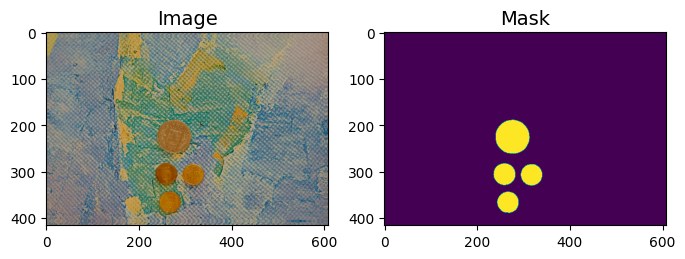

In [10]:
img, mask, _ = train_ds[7]
plot_images(image=img, mask=mask.squeeze(0))

In [31]:
# create dataloaders
train_loader = DataLoader(train_ds, batch_size=8)
val_loader = DataLoader(val_ds, batch_size=8)

###  Modelling

We use `Segmentation Models Pytorch` library as it offers convenient interface for creating segmentation models. For unified encapsulation (we will create special model class for classification), we created a wrapper around the segmentation model called `CoinLocalizer`.

<font color='red'>Notice that you don't need to run it for testing purposes.  We have already trained the model, so you can just skip this part if needed. and continue from **feature extraction and classification**.</font>

In [ ]:
# training hyperparameters
num_epochs = 30
batch_size = 4
lr = 0.005

In [20]:
# create the model instance
model = CoinLocalizer()

In [21]:
# find the parameters that needs to be tuned
trainable_params = [param for param in model.parameters() if param.requires_grad == True]
optimizer = torch.optim.Adam(trainable_params, lr=lr)

# specify scheduler and criterion
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

In [22]:
# train the model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs
)

Epoch:   1. Train.      Loss: 0.631 | f1: 0.568: 100%|██████████| 17/17 [01:17<00:00,  4.55s/it]
Epoch:   1. Validation. Loss: 0.834 | f1: 0.170: 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]
Epoch:   2. Train.      Loss: 0.135 | f1: 0.898: 100%|██████████| 17/17 [01:09<00:00,  4.09s/it]
Epoch:   2. Validation. Loss: 0.193 | f1: 0.813: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]
Epoch:   3. Train.      Loss: 0.074 | f1: 0.929: 100%|██████████| 17/17 [01:09<00:00,  4.10s/it]
Epoch:   3. Validation. Loss: 0.119 | f1: 0.884: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]
Epoch:   4. Train.      Loss: 0.068 | f1: 0.936: 100%|██████████| 17/17 [01:09<00:00,  4.10s/it]
Epoch:   4. Validation. Loss: 0.124 | f1: 0.875: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]
Epoch:   5. Train.      Loss: 0.051 | f1: 0.952: 100%|██████████| 17/17 [01:09<00:00,  4.11s/it]
Epoch:   5. Validation. Loss: 0.126 | f1: 0.876: 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]
Epoch:   6. Train.      Loss: 0.048 | f1

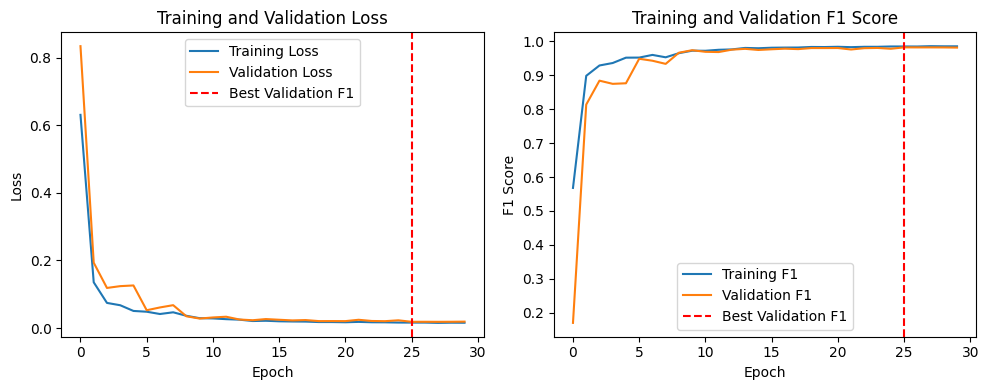

In [25]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

### Hough Transform

As we can see from the charts above, the model converged quickly and has near perfect performance on both training and validation set. We might have overfitted a bit, but as the loss kept slowly decreasing, we will keep it as it is. As we now have clean binary mask, we can localize coins by using Hough transform. It is a technique which can be used to isolate features of a particular shape within an image, which in our case is circle.

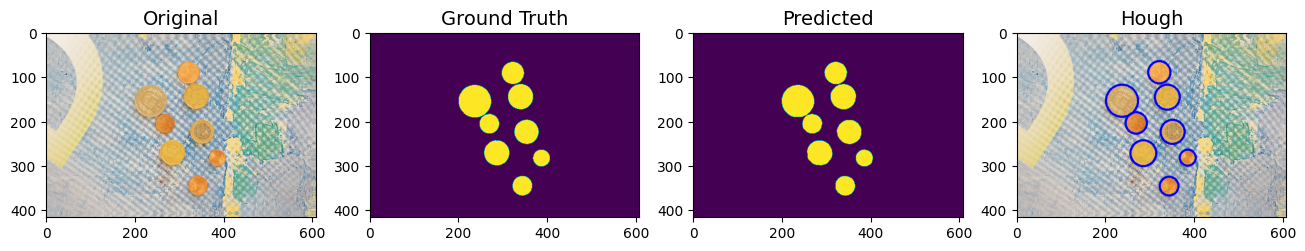

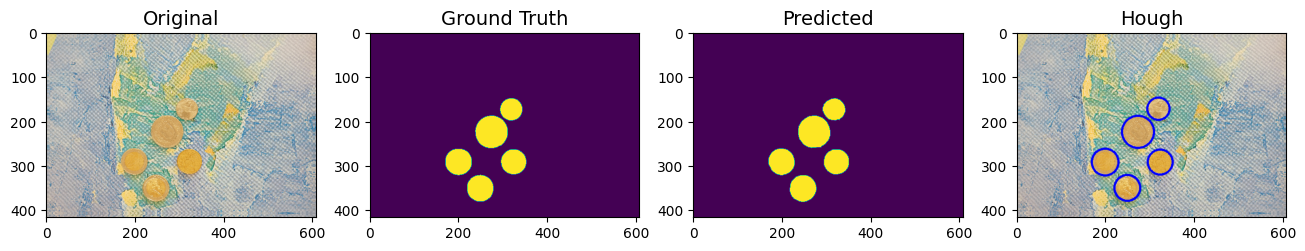

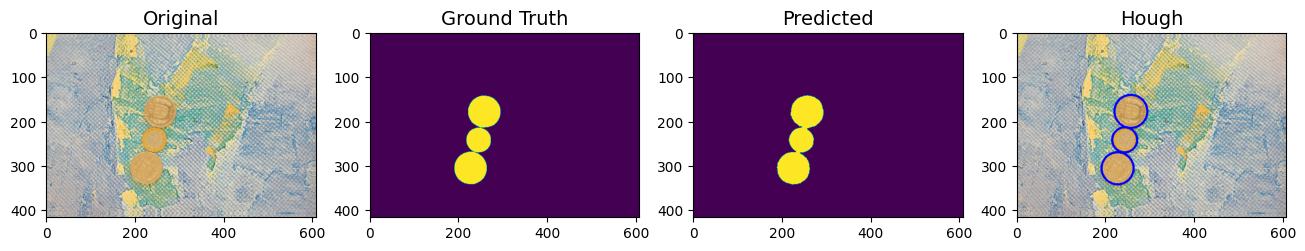

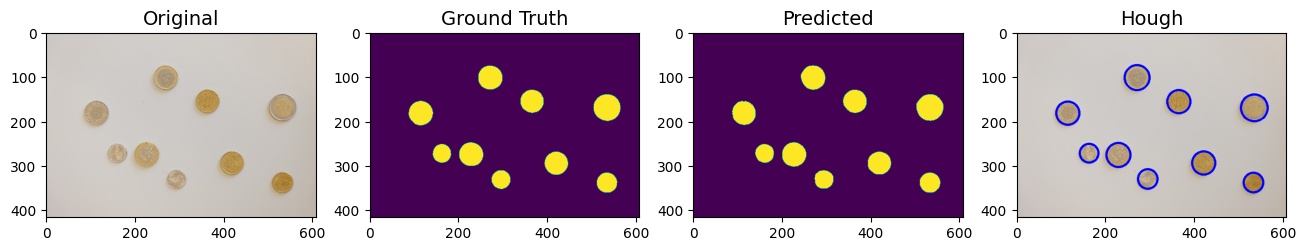

In [22]:
for images, labels, _ in val_loader:

    for image, label in zip(images, labels):
        predicted = get_segmentation(model, image.unsqueeze(0))
        circles, hough_img = generate_hough(predicted, image)

        plot_images(
            original=image,
            ground_truth=label,
            predicted=predicted,
            hough=hough_img[:, :, ::-1]  # bgr -> rgb
        )

    break  # visualize only one batch

The images below show that the segmentation model works surprisingly well even with more complex backgrounds in the training data as the binary predicted mask is really close to the ground truth. What is more, Hough Transforms with tuned parameters has no trouble locating coins on the binary images. We added another layer before final Hough' output that filters out circles that are inside the bigger one (function `filter_circles` in `utils` module). This way we don't have duplicated coins. 

## Feature Extraction and Classification

Now that we have localized the coins, we need to classify them by first extracting features and then building a classifier that would output the final decision given the feature vector. We first experimented with manual feature extraction and then continued with neural networks that showed significantly better performance.

### Manual Feature Extraction

[paragraph about Armando's work and reference to the notebook]

### Neural Network Approach

#### Setup

Since manual methods didn't yield the expected results, we decided to use a neural network with a pretrained backbone for meaningful feature extraction and a classification head for determining the class. We chose the [Vision Transformer](https://huggingface.co/timm/vit_small_patch16_224.augreg_in1k) as the backbone due to its state-of-the-art performance. This architecture has been trained on ImageNet-1k and uses a patch size of 16x16.

Our dataset consists of coins from two different currencies. Additionally, CHF coins have heads and tails, meaning that one class may have multiple correct representations. To address this, we developed a neural-network decision tree comprising several models, each focusing on a specific classification task:

- Predicting currency: EUR or CHF (2 classes)
- Predicting EUR coin types: Any of the EUR coin types (8 classes)
- Predicting if CHF is heads or tails: 2 classes
- Predicting CHF tails (with numbers): 7 classes
- Predicting CHF head image: 3 classes

There are two nuances that are important to highlight. First, when the model is not too confident about the outcome, we will assign it as `OOD`. Secondly, CHF coins feature the same design on the heads side, with the only difference being the coin size. Since coin size impacts the image, we couldn't let the model predict the specific coin type based solely on the image or radius. Instead, we focused on predicting the image type:

- '5CHF'
- '2CHF/1CHF/0.5CHF'
- '0.2CHF/0.1CHF/0.05CHF'

We then applied an image-specific approach using the `make_final_decision` method in the `HierarchicalClassifier` class from the `scripts.models` module:

1. Select the coin that the models are most confident about.
2. Compare its size with the size of the coin in the image.
3. Compare the actual sizes obtained from the internet and specified in config.py ('2CHF/1CHF/0.5CHF' or '0.2CHF/0.1CHF/0.05CHF').
4. Choose the coin type with the smallest difference between the expected and actual size ratio.

The figure below illustrates the decision process:
<br>
<img src="figures/process_chart.png" width="1200"/>


#### Training

In order to train the model, we manually annotated the training images with bounding boxes and correct coin types using [Roboflow](https://roboflow.com/). We then implemented function `get_images_from_coco` in module `scripts.utils` that cuts the coins from the images and saves them to `data/classification` directory. We then removed OOD coins from the training data and created pipeline that would be able to relabel the coins depending on the model we train. The training process can be seen in `notebooks/classification.ipynb` (no need to rerun it, the models have been saved to `models` directory).

For some of the models we have frozen the encoder as just tuning classification head was enough. The models with more output classes, however, showed better evaluation results when encoder was also fine-tuned with small learning rate. The following table depicts the most important parameters of the training:

<br>

| Model              | Number of Classes | Encoder Frozen | Epochs Trained | Learning Rate |
| ------------------ | ----------------- | -------------- | -------------- | ------------- |
| Currency           | 2                 | True           | 20             | 5e-4          |
| EUR                | 8                 | False          | 20             | 5e-5          |
| CHF heads/tails    | 2                 | True           | 30             | 1e-3          |
| CHF tail coin type | 7                 | False          | 20             | 5e-6          |
| CHF head image     | 3                 | False          | 20             | 3e-5          |

#### Inference

After the models have been trained, we created `torch.Module` called `HierarchicalClassifier` (in `scripts.models`) that would load all classification models and would output the list with respective coin counts.

In [6]:
# specify the directory and read the data
test_directory = "data/test"
test_image_paths, _, _, _ = split_data(test_directory, 0.0, 'inference')

In [7]:
# create test transforms (only resize and add imagenet normalization)
seg_tf = A.Compose([
    A.Resize(width=600, height=400, always_apply=True),
    A.PadIfNeeded(min_height=416, min_width=608, always_apply=True),
])

cls_tf = A.Compose([
    A.Resize(width=224, height=224, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True)
])

In [8]:
# generate Dataset and DataLoader
test_ds = MergedTrainingDataset(
    image_paths=test_image_paths,
    transform=seg_tf
)

test_loader = DataLoader(test_ds, batch_size=1)

In [9]:
# load the model
model = HierarchicalClassifier()

device = get_best_available_device()
model = model.to(device)

In [ ]:
# make the inference, save images with bounding boxes and update df
df = pd.DataFrame(columns=example_row)

stream = tqdm(test_loader, desc='Analyzing images')
for i, (image, original_img, _, filename) in enumerate(stream):
    image = image.to(device)

    row, bboxes, labels = model(image, original_img)

    prob_img = draw_bounding_boxes(
        image=original_img.squeeze(0).permute(2, 0, 1),
        boxes=bboxes,
        labels=labels,
        colors="#FF0000",
        font="Arial",
        width=16,
        font_size=110
    )

    df.loc[filename[0]] = row.detach().numpy()

    im = Image.fromarray(prob_img.cpu().numpy().transpose(1, 2, 0))
    im.save(f"inference/{filename[0]}.JPG")

In [ ]:
# add index name as necessary for Kaggle and save csv
df.index.name = 'id'
df.head()
df.to_csv('test_submission.csv')

<img src="figures/example_inference.jpg" width="1200"/>
<br>
Our approach gives us test f1 score ~83%. While currency classification seem to be working really well, the confidence levels are not always accurate. What is more, the currency specific models that need to predict 8 or 7 classes, tend to have lower out-of-sample accuracy than the ones generating binary classification or predicting 3 separate classes.

### Alternative Approaches Explored

The following paragraphs describe measures we also tried, but that didn't yield better performance.

####

